# **Case Study - Identifying Relavant US Economy News Articles**

The dataset below consists of 8000 news articles annotated with whether or not they're relavant to US economy (i.e., a yes/no binary classification). The dataset is known to be imbalanced.

### **Reading the data and basic EDA**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/full_economic_news_articles.csv", encoding="latin1")

df.head()

,relevance,articleid,date,headline,text
0,yes,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,no,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,no,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,no,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,yes,wsj_398838054,10-04-2002,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
df.shape

(8000, 5)

In [4]:
# Relevant Article: Talks about Economy

df.loc[0, 'text']

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [5]:
# Non Relevant Article: Looks like talking about Health Insurance

df.loc[1, 'text']

'The Wall Street Journal Online</br></br>The Morning Brief, a look at the day\'s biggest news, is emailed to subscribers by 7 a.m. every business day. Sign up for the e-mail here.</br></br>On Friday evening, with Congress out of town on its summer recess and Americans heading into a mid-August weekend, the Bush administration sent a message to the states: The federal government will make it tougher for a national children\'s insurance program to cover the offspring of middle-income families.</br></br>The State Children\'s Health Insurance Program was created in 1997 to help children whose families couldn\'t afford insurance but didn\'t qualify for Medicaid, and administration officials tell the New York Times that the changes are aimed at returning the program to its low- income focus and assuring it didn\'t become a replacement for private insurance. Administration point man Dennis Smith wrote to state officials saying there would be new restrictions on the District of Columbia and th

In [6]:
# Distribution on target variable looks non-uniform

df['relevance'].value_counts(normalize=True)

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: proportion, dtype: float64

In [7]:
# Visuallizing an overall Word Cloud from the given data

from wordcloud import WordCloud

wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['text']))

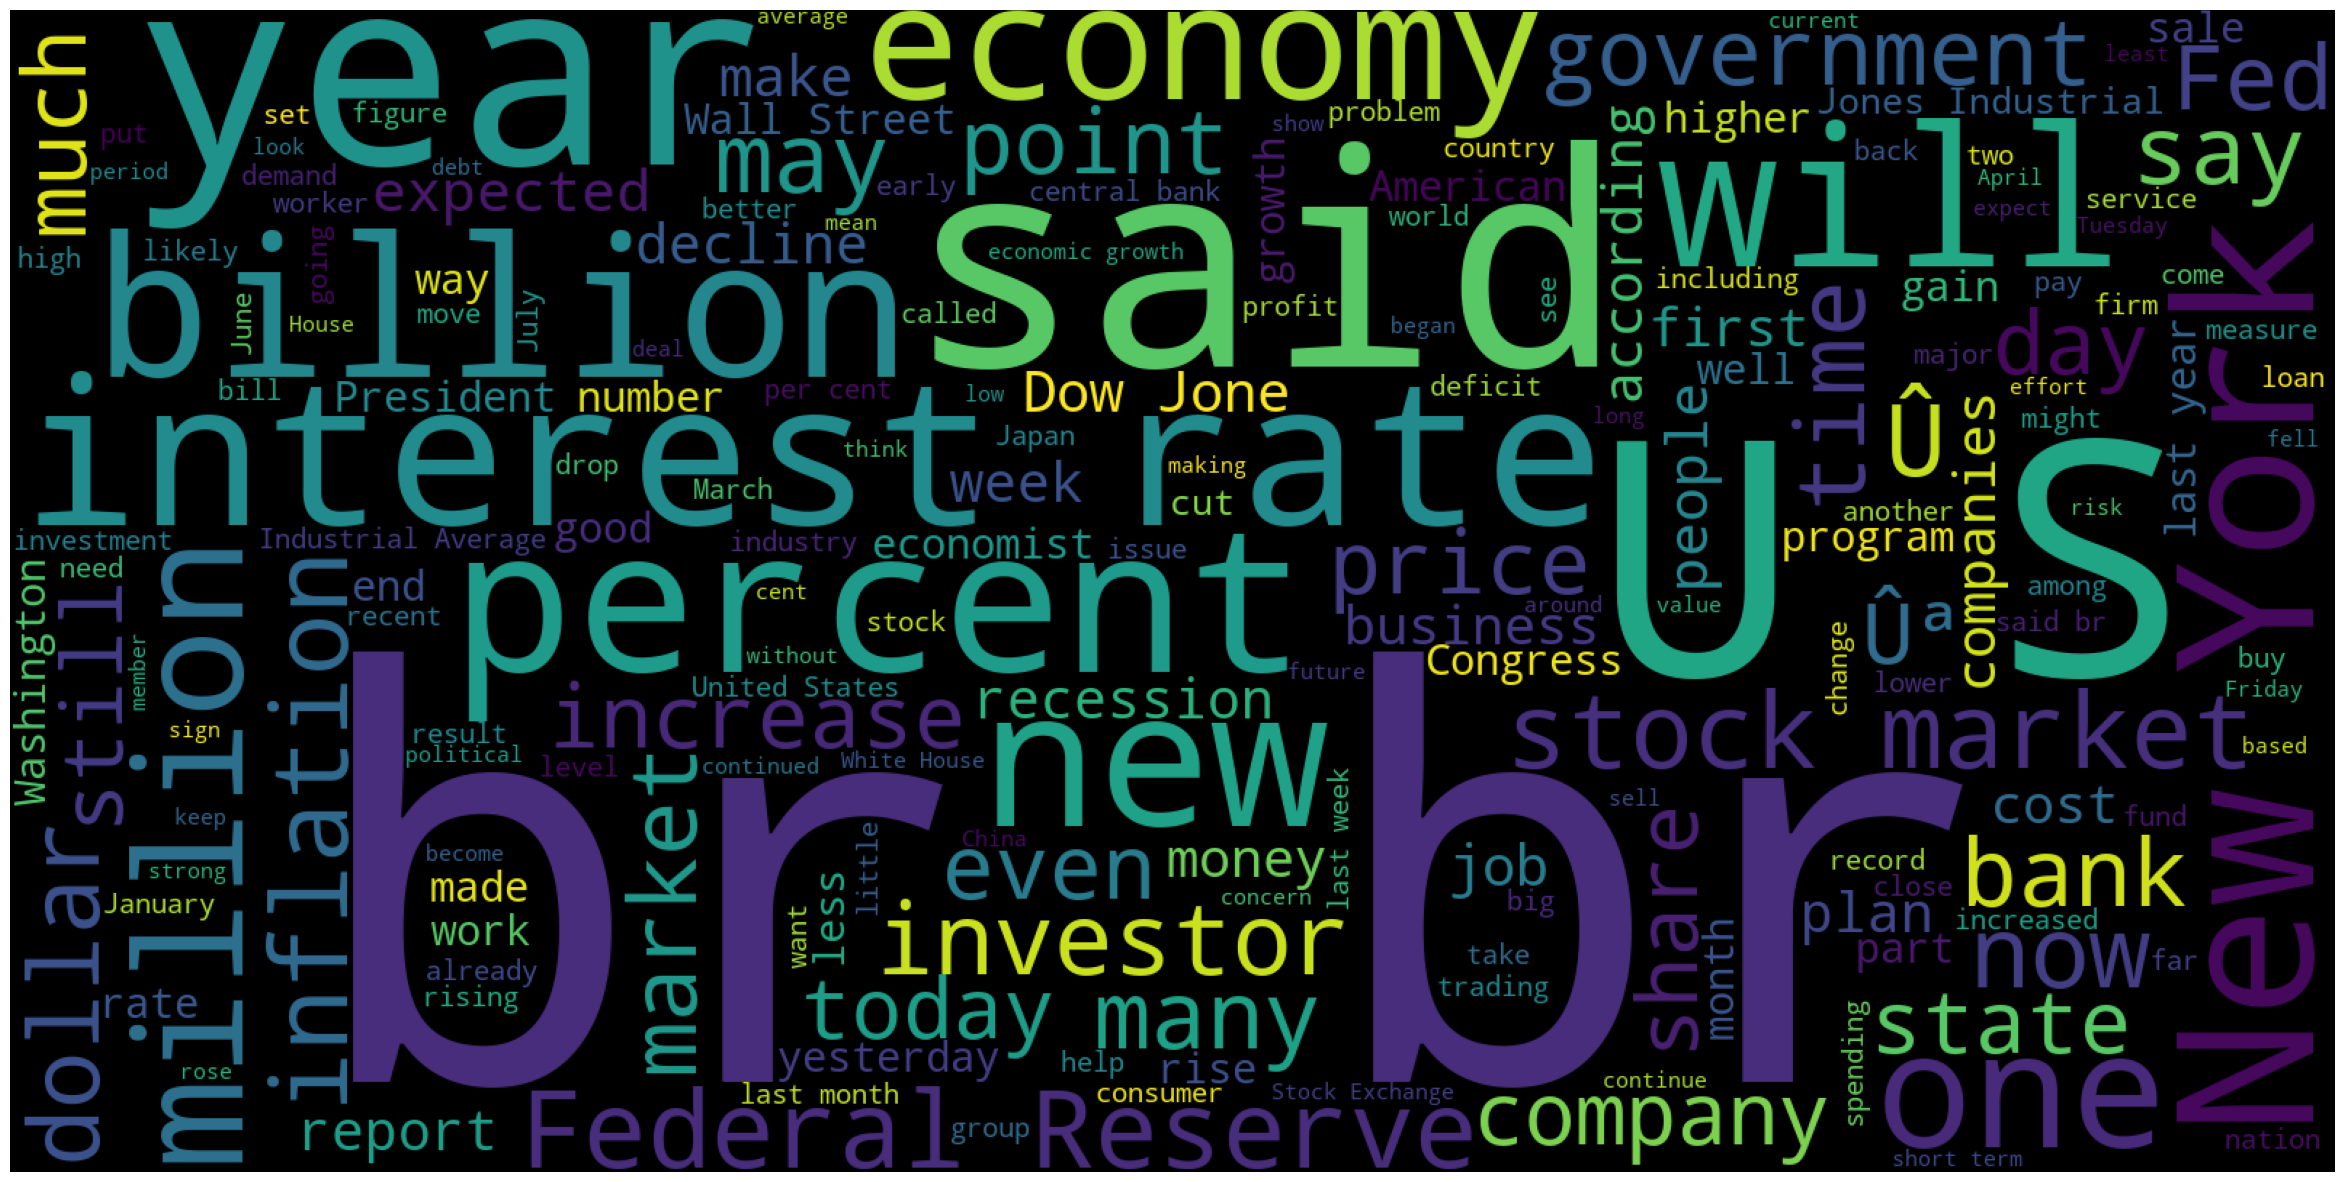

In [8]:
import matplotlib.pyplot as plt

plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

There is an imbalance in the data with **not relevant** being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [9]:
# removing the data where we don't want relevance="not sure".
df = df[df.relevance != "not sure"]

df.shape

(7991, 5)

In [10]:
# convert label to a numerical variable
df['relevance'] = df.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 

# Let us take only the two columns we need
df = df[["text", "relevance"]] 
df.shape

(7991, 2)

### **Step 1 - Identify Input and Output**

In [11]:
# Step 1: Identify Input and Output

X = df.text # the column text contains textual data to extract features from
y = df.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)

(7991,) (7991,)


### **Step 2 - Split the Data into Train and Test**

In [12]:
# Step 2: Split the data into train and test

from sklearn.model_selection import train_test_split

# split X and y into training and testing sets. 
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5993,) (5993,)
(1998,) (1998,)


### **Step 3 - Data Preprocessing on train data (X_train)**

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def display_wordcloud(data):
    wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(data))
    plt.figure(1,figsize=(30,20))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

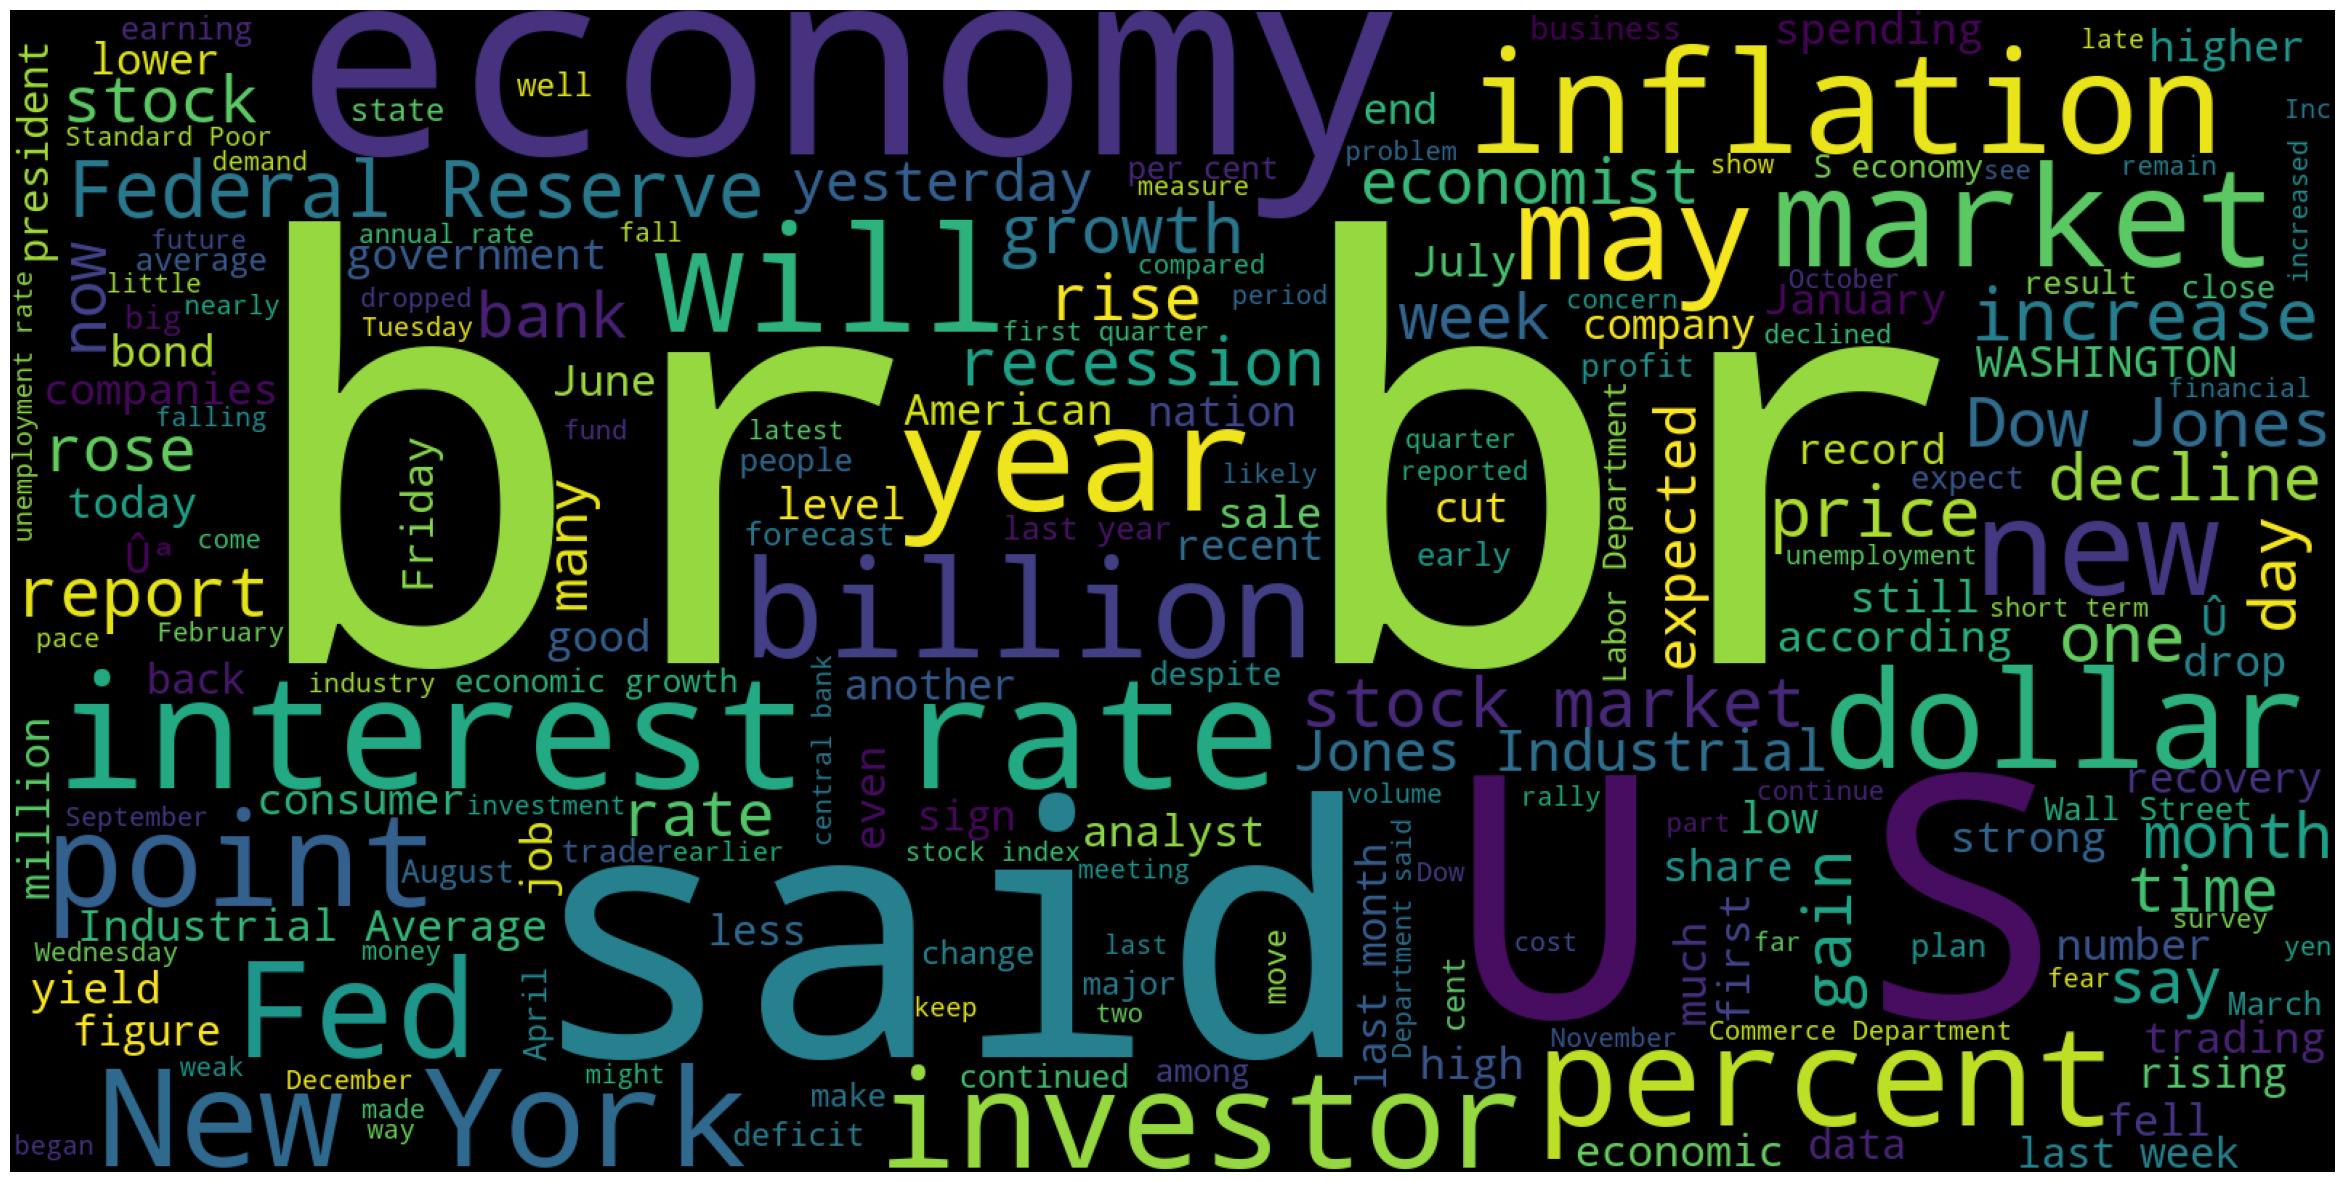

In [14]:
display_wordcloud(X_train[y_train==1])

In [15]:
# Step 3: Data Preprocessing on train data (X_train)

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [16]:
# nltk.download('wordnet')

In [17]:
def clean(doc): # doc is a string of text
    # This text contains a lot of <br/> tags.
    doc = doc.replace("</br>", " ")
    
    # Remove punctuation and numbers.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [18]:
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: total: 12.4 s
Wall time: 12.6 s
(5993, 39644)


### **Step 4 - Data Preprocessing on test data (X_test)**

In [19]:
# Step 4: Data Preprocessing on test data (X_test)

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(1998, 39644)


### **Step 5 - Building a Model (i.e. Train the classifier)**

In [20]:
# Step 5: Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 0 ns
Wall time: 5.98 ms


MultinomialNB()

### **Step 6 - Evaluating on Train Data**

In [21]:
# Step 6: Evaluate on train data

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.confusion_matrix(y_train, y_train_pred)

array([[4110,  805],
       [ 255,  823]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

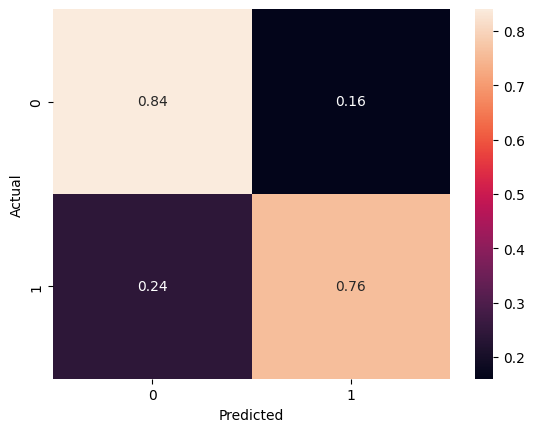

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### **Step 7 - Evaluate on Test Data**

In [23]:
# Step 7: Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.confusion_matrix(y_test, y_test_pred)

array([[1384,  272],
       [ 184,  158]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

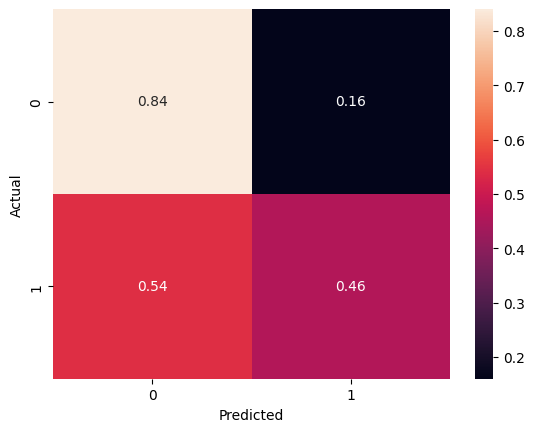

In [24]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. 

**Potential Reasons for poor classifier performance**
1. Perhaps we need to balance the data - Clearly there is class imbalance
2. Perhaps we need a better learning algorithm - Implement Logistic Regression, SVM, RF, etc...
3. Perhaps we should look for tuning the classifier's parameter with the help of Hyperparameter Tuning
4. Perhaps we need a better pre-processing and feature extraction mechanism - Right now we have a sparse and large feature vector

**Let's work with potential reason number 4.**  
Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

### **Going Back and Applying all the Steps Again**

In [25]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train) # use it to extract features from training data

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 5000) (1998, 5000)


In [26]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_test_pred = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: total: 31.2 ms
Wall time: 6.98 ms


Text(0.5, 23.52222222222222, 'Predicted')

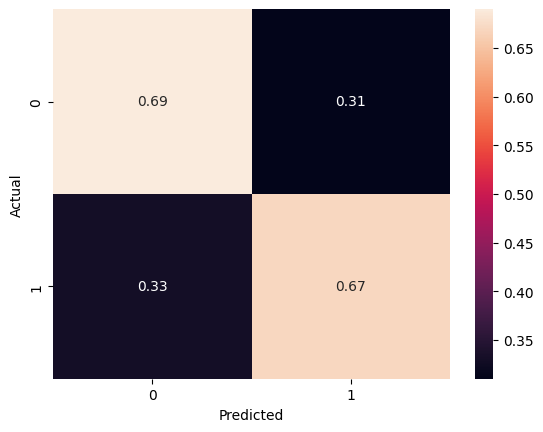

In [27]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Clearly, the performance on relevance classification got better.

## **Introducing Pipelines for Optimal Workflow**

Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling.

Intermediate steps of the pipeline must be ‘transformers’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.

Pipelines are important because 
1. **Efficient Hyperparameter Tuning:** Using pipelines also allows for hyperparameter tuning and cross-validation to be performed more efficiently, as the entire pipeline can be treated as a single estimator. This makes it easier to search over a space of hyperparameters and evaluate different configurations. Overall, pipelines promote code modularity, reusability, and reproducibility in machine learning projects.
2. **Automate ML Workflows:** They help automate machine learning workflows by sequentially applying a series of preprocessing steps followed by a model fitting step. This ensures that all preprocessing steps are applied consistently to both the training and testing data, avoiding data leakage and making the code more readable and maintainable.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

In [32]:
pipe = Pipeline(
    [
        ('preprocessing', CountVectorizer()),
        ('nb', MultinomialNB())
    ]
)

MAX_FEATURES = [500, 1000, 1500, 2000]
ALPHA = [1, 10, 100]

# Observe the Key Value Pair format
parameter_grid = [{'preprocessing__preprocessor' : [clean],
                     'preprocessing__max_features' : MAX_FEATURES, 
                     'nb__alpha' : ALPHA}]


clf = GridSearchCV(
    estimator=pipe, 
    param_grid=parameter_grid, 
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    verbose=1
)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid=[{'nb__alpha': [1, 10, 100],
                          'preprocessing__max_features': [500, 1000, 1500,
                                                          2000],
                          'preprocessing__preprocessor': [<function clean at 0x000002223EC49D30>]}],
             return_train_score=True, scoring='accuracy', verbose=1)

**Above code takes upto 30 minutes to execute**

In [33]:
print("Best parameters set found on train set")
print(clf.best_params_)
print(clf.best_estimator_)
print()

print('Score on Test Data: ', clf.score(X_test, y_test))

Best parameters set found on train set
{'nb__alpha': 100, 'preprocessing__max_features': 1500, 'preprocessing__preprocessor': <function clean at 0x000002223EC49D30>}
Pipeline(steps=[('preprocessing',
                 CountVectorizer(max_features=1500,
                                 preprocessor=<function clean at 0x000002223EC49D30>)),
                ('nb', MultinomialNB(alpha=100))])

Score on Test Data:  0.8193193193193193


In [ ]:
cv_results = pd.DataFrame(clf.cv_results_)

cv_results.head()

In [ ]:
plt.plot(cv_results['param_n_neighbors'], cv_results['mean_train_score'])
plt.plot(cv_results['param_n_neighbors'], cv_results['mean_test_score'])
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend(['train accuracy', 'test accuracy'], loc='upper right')